* Objective: 

The initiative is carried out to understand commission paid to the partners and to identify any unusual payment at any point in time as compared to previous payments. <br>

* Current Status: 
1. For every partner if the payments in consecutive months are greater or smaller than a pre-defined threshold (business is using 10% for now), the associated partner commission will be flagged for                      further investigation.

2. We have created a pipeline which will differentiate whether a payment is an out-lier or not 
 
* Future: 

We will aggregate the results from above and create an accuracy score for each partner <br>

* Usage/Application: 

The results will populate a dashboard which will be used in commission sign off meeting to filter partners with higher than expected commission payments

## Steps

#### Import data
* Extract data from BQ, this will include partner commission data and RFM data

#### Clean and wrangle data for usage
* Change datatype where necessary
* Quality check for duplicates, every partner shuld have one entry for each month
* Identify parners who are paid the most (above 95th percentile)
* Impute missing values
        * remove all those where rfm catgeory is null
        * Remove those partners whose rfm category is null
        * Replace recency, frequency and vaue with median value for those where all three are null but rfm category is not null
* Match outputs from uncleaned and cleaned data and test if anything missing is reminaing in any columns

####  Create data with differences in total commission value
* First we get all columns which are needed (partner id, commision year, commission month and commission value
* Sort the data on partner id, commision year, commission month
* Calculate percent change from month to month for every partner
* If the percent change is either less than -10% or greater than 10%, the corresponding partner is not paid correctly


#### Outlier Detection by diferent algorithms
* Create a dataset from january to July in 2021 (training data)
* Understand and plot commission values to see the distribution (using boxplot and distribution lot)

#### Import libraries

In [1]:
# !pip install pyod

In [2]:
from utils.shuqing_all import *

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn 
import os

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('fivethirtyeight')
five_thrity_eight=[
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",    
]
sns.set_palette(five_thrity_eight)
PROJECT = 'uw-data-warehouse-prod'

#### Import data
* Extract data from BQ, this will include partner commission data and RFM data


In [4]:
query = '''

with live as (
    SELECT snapshot_date, partner_position_id 
    FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_live`
    WHERE is_live)
, value as (
    SELECT snapshot_date, partner_position_id, partner_value_last_1y as value
    FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_value_last_period`)
, frequency as (
    SELECT snapshot_date, partner_position_id, customers_gathered_last_1y as frequency
    FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.customers_gathered_last_period`) 
, recency as (
    SELECT snapshot_date, partner_position_id, days_since_last_activity as recency 
    FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.days_since_last_activity`)


, title as (
    SELECT snapshot_date, partner_position_id,title,
    CASE 
    WHEN title = 'D' THEN 'group_1' 
    WHEN title IN ('QD', 'TL', 'STL') THEN 'group_2'
    WHEN title IN ('GL', 'SGL', 'NNL', 'NGL') THEN 'group_3'
    ELSE NULL END as title_group,
    FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_title`
    )

, commission as (select a.partner_position_id
, a.commission_period.year
, a.commission_period.month
, a.ri_total.value as ri_value
, a.commission_total.value as commission_value
, a.total.value as total_value
from `uw-partner-prod.commission_totalling_v1.partner_position_commission_total_calculated_cleaned` a
WHERE commission_period.year in (2021)
),

-- Get bonus paid and returned, data is on monthly level
bonus_paid_and_returned AS (
        SELECT Partner_position_id, year, month, total_bonus_paid, total_bonus_returned 
        FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_supporting_bonus_by_commission_month`
        where year in (2020, 2021)
),

-- get personally gathered customers, this was on daily basis, we took most recent value for every month
personal_customer_gathered AS (
select partner_position_id, month, year, customers_gathered_last_1d, customers_gathered_last_30d from (
        select snapshot_date, DATE_SUB(snapshot_date, INTERVAL (EXTRACT(DAY FROM snapshot_date)-1) day) as first_day_of_month,
        EXTRACT(MONTH FROM snapshot_date) as month, EXTRACT(YEAR FROM snapshot_date) as year,
        partner_position_id, customers_gathered_last_1d, customers_gathered_last_30d 
        from `uw-data-models-prod.partner_dataform_models_feature_catalogue.customers_gathered_last_period_v2`
) where snapshot_date = first_day_of_month
),

-- get customers gained by any way, this was on daily basis, we took most recent value for every month
Customers_gained_by_any_other_method as (
 select partner_position_id, month, year, customers_gained_last_1d, customers_gained_last_30d from (
select snapshot_date, DATE_SUB(snapshot_date, INTERVAL (EXTRACT(DAY FROM snapshot_date)-1) day) as first_day_of_month
, EXTRACT(MONTH FROM snapshot_date) as month, EXTRACT(YEAR FROM snapshot_date) as year,
        partner_position_id, customers_gained_last_1d, customers_gained_last_30d  
from  `uw-data-models-prod.partner_dataform_models_feature_catalogue.customers_gained_last_period`
) where snapshot_date = first_day_of_month  
),

-- plus club memebership, this was on daily basis, we took most recent value for every month
plus_club_membership as (
 select partner_position_id, month, year, club from (
select a.*, DATE_SUB(snapshot_date, INTERVAL (EXTRACT(DAY FROM snapshot_date)-1) day) as first_day_of_month
, EXTRACT(MONTH FROM snapshot_date) as month, EXTRACT(YEAR FROM snapshot_date) as year 
from `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_plus_club_membership` a
) where snapshot_date = first_day_of_month
),

rfm_score as (
    select partner_position_id, rfm_score, rfm_category from `uw-data-models-prod.partner_dataform_models_position.rfm_score` 
)

select a.*
, b.ri_value
, b.commission_value
, b.total_value
, c.total_bonus_paid
, c.total_bonus_returned
, d.customers_gathered_last_1d
, d.customers_gathered_last_30d
, e.customers_gained_last_1d
, e.customers_gained_last_30d
, f.club
, g.rfm_score
, g.rfm_category
 from (
            SELECT live.partner_position_id
            , EXTRACT(MONTH from live.snapshot_date) as month
            , EXTRACT(YEAR from live.snapshot_date) as year
            , title.title
            , title.title_group 
            , rec.recency 
            , freq.frequency 
            , val.value 
            FROM  live live 
            LEFT JOIN title  title on live.partner_position_id = title.partner_position_id and live.snapshot_date = title.snapshot_date
            LEFT JOIN recency  rec on live.partner_position_id = rec.partner_position_id and live.snapshot_date = rec.snapshot_date
            LEFT JOIN frequency freq on live.partner_position_id = freq.partner_position_id and live.snapshot_date = freq.snapshot_date
            LEFT JOIN value val on live.partner_position_id = val.partner_position_id and live.snapshot_date = val.snapshot_date 
            WHERE EXTRACT(DAY from live.snapshot_date) = 1
) a
left join commission b on a.partner_position_id = b.partner_position_id and a.month = b.month and a.year = b.year 
left join bonus_paid_and_returned c on a.partner_position_id = c.partner_position_id and a.month = c.month and a.year = c.year
left join personal_customer_gathered d on a.partner_position_id = d.partner_position_id and a.month = d.month and a.year = d.year
left join Customers_gained_by_any_other_method e on a.partner_position_id = e.partner_position_id and a.month = e.month and a.year = e.year
left join plus_club_membership f on a.partner_position_id = f.partner_position_id and a.month = f.month and a.year = f.year
left join rfm_score g on a.partner_position_id = g.partner_position_id
order by a.partner_position_id, a.year, a.month

'''

In [5]:
raw_df=download_data(project_id=PROJECT,query=query)

Downloading:   0%|          | 0/429728 [00:00<?, ?rows/s]

In [6]:
print(raw_df.shape)

(429728, 20)


In [7]:
raw_df.head()

,partner_position_id,month,year,title,title_group,recency,frequency,value,ri_value,commission_value,total_value,total_bonus_paid,total_bonus_returned,customers_gathered_last_1d,customers_gathered_last_30d,customers_gained_last_1d,customers_gained_last_30d,club,rfm_score,rfm_category
0,000198,1,2021,D,group_1,5082,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
1,000198,2,2021,D,group_1,5113,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
2,000198,3,2021,D,group_1,5141,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
3,000198,4,2021,D,group_1,5172,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
4,000198,5,2021,D,group_1,5202,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant


#### Clean and wrangle data for usage
* Change datatype where necessary
* extract values appropriately and then merge to create one table

In [8]:
raw_df.dtypes

partner_position_id             object
month                            int64
year                             int64
title                           object
title_group                     object
recency                          int64
frequency                      float64
value                           object
ri_value                        object
commission_value                object
total_value                     object
total_bonus_paid               float64
total_bonus_returned           float64
customers_gathered_last_1d     float64
customers_gathered_last_30d    float64
customers_gained_last_1d       float64
customers_gained_last_30d      float64
club                            object
rfm_score                      float64
rfm_category                    object
dtype: object

* Quality check for duplicates, every partner shuld have one entry for each month

In [9]:
## quality check no duplicates per commission_month and partner_position_id
(raw_df.groupby(['year','month','partner_position_id']).count()==1).sum()

title                          429728
title_group                    429728
recency                        429728
frequency                      286636
value                          429728
ri_value                       422424
commission_value               422424
total_value                    422424
total_bonus_paid                 1742
total_bonus_returned             1742
customers_gathered_last_1d     286627
customers_gathered_last_30d    286627
customers_gained_last_1d       313778
customers_gained_last_30d      313778
club                            68676
rfm_score                      374278
rfm_category                   374278
dtype: int64

In [10]:
raw_df.isna().sum()

partner_position_id                 0
month                               0
year                                0
title                               0
title_group                         0
recency                             0
frequency                      143092
value                               0
ri_value                         7304
commission_value                 7304
total_value                      7304
total_bonus_paid               427986
total_bonus_returned           427986
customers_gathered_last_1d     143101
customers_gathered_last_30d    143101
customers_gained_last_1d       115950
customers_gained_last_30d      115950
club                           361052
rfm_score                       55450
rfm_category                    55450
dtype: int64

In [11]:
new_commission = raw_df.copy()

* Understanding the data , check shape, first few rows or may be filter for one partner to understand the data a bit better
* Check for RFM category and how mny unique partners are associated to them


In [12]:
new_commission.shape

(429728, 20)

In [13]:
new_commission.head()

,partner_position_id,month,year,title,title_group,recency,frequency,value,ri_value,commission_value,total_value,total_bonus_paid,total_bonus_returned,customers_gathered_last_1d,customers_gathered_last_30d,customers_gained_last_1d,customers_gained_last_30d,club,rfm_score,rfm_category
0,000198,1,2021,D,group_1,5082,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
1,000198,2,2021,D,group_1,5113,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
2,000198,3,2021,D,group_1,5141,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
3,000198,4,2021,D,group_1,5172,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
4,000198,5,2021,D,group_1,5202,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant


In [14]:
# Check the data for a partner in detail
new_commission[new_commission['partner_position_id']=='000198'].sort_values(by=['year','month'])

,partner_position_id,month,year,title,title_group,recency,frequency,value,ri_value,commission_value,total_value,total_bonus_paid,total_bonus_returned,customers_gathered_last_1d,customers_gathered_last_30d,customers_gained_last_1d,customers_gained_last_30d,club,rfm_score,rfm_category
0,000198,1,2021,D,group_1,5082,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
1,000198,2,2021,D,group_1,5113,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
2,000198,3,2021,D,group_1,5141,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
3,000198,4,2021,D,group_1,5172,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
4,000198,5,2021,D,group_1,5202,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
5,000198,6,2021,D,group_1,5233,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
6,000198,7,2021,D,group_1,5263,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
7,000198,8,2021,D,group_1,5294,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant
8,000198,9,2021,D,group_1,5325,0.0,0E-9,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant


In [15]:
print("Starting Year", new_commission['year'].min(), "Ending Year =",new_commission['year'].max())
print("Starting Month", new_commission['month'].min(), "Ending Month =",new_commission['month'].max())
print("#Unique partners = ",new_commission['partner_position_id'].nunique())

Starting Year 2021 Ending Year = 2021
Starting Month 1 Ending Month = 9
#Unique partners =  56155


In [16]:
new_commission.groupby('rfm_category').partner_position_id.nunique()

rfm_category
dormant                41002
engaged                    4
semi-dormant-high         13
semi-dormant-low        2536
semi-dormant-medium       61
Name: partner_position_id, dtype: int64

* Check missing values

In [17]:
new_commission.isna().sum()

partner_position_id                 0
month                               0
year                                0
title                               0
title_group                         0
recency                             0
frequency                      143092
value                               0
ri_value                         7304
commission_value                 7304
total_value                      7304
total_bonus_paid               427986
total_bonus_returned           427986
customers_gathered_last_1d     143101
customers_gathered_last_30d    143101
customers_gained_last_1d       115950
customers_gained_last_30d      115950
club                           361052
rfm_score                       55450
rfm_category                    55450
dtype: int64

* Impute missing values
* remove all those where rfm catgeory is null
* Remove those partners whose rfm category is null
* Replace recency, frequency and vaue with median value for those where all three are null but rfm category is not null
* removed records with no title information


In [18]:
# Get parttners whose rfm_category is null

new_commission_cleaned = new_commission[new_commission['rfm_category'].notnull()]
new_commission_cleaned = new_commission_cleaned[new_commission_cleaned['commission_value'].notnull()]
new_commission_cleaned.shape

(374114, 20)

In [19]:
rfm_table = new_commission_cleaned.groupby(['rfm_score']).agg({'recency':'median', 'frequency':'median', 'value':'median'}).reset_index()
rfm_table

,rfm_score,recency,frequency,value
0,0.0,1016.0,0.0,0.00
1,1.0,111.0,2.0,3.20
2,2.0,86.0,2.0,12.10
3,3.0,65.0,2.0,13.30
4,4.0,76.0,3.0,15.60
5,5.0,28.0,10.0,70.10
6,6.0,18.0,15.0,125.40
7,7.0,9.0,28.0,248.20
8,8.0,6.0,36.0,329.20
9,9.0,5.0,52.0,528.90


In [20]:
new_commission_cleaned= new_commission_cleaned.merge(rfm_table, on= 'rfm_score', how='left')

new_commission_cleaned['recency'] = np.where(new_commission_cleaned['recency_x'].notnull(),new_commission_cleaned['recency_x'], new_commission_cleaned['recency_y'])
new_commission_cleaned['frequency'] = np.where(new_commission_cleaned['frequency_x'].notnull(),new_commission_cleaned['frequency_x'], new_commission_cleaned['frequency_y'])
new_commission_cleaned['value'] = np.where(new_commission_cleaned['value_x'].notnull(),new_commission_cleaned['value_x'], new_commission_cleaned['value_y'])

new_commission_cleaned = new_commission_cleaned.drop(['recency_x', 'recency_y', 'frequency_x', 'frequency_y','value_x', 'value_y' ],axis=1)
new_commission_cleaned = new_commission_cleaned[new_commission_cleaned.title_group.notna()]
new_commission_cleaned.head()

,partner_position_id,month,year,title,title_group,ri_value,commission_value,total_value,total_bonus_paid,total_bonus_returned,customers_gathered_last_1d,customers_gathered_last_30d,customers_gained_last_1d,customers_gained_last_30d,club,rfm_score,rfm_category,recency,frequency,value
0,000198,1,2021,D,group_1,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant,5082.0,0.0,0E-9
1,000198,2,2021,D,group_1,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant,5113.0,0.0,0E-9
2,000198,3,2021,D,group_1,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant,5141.0,0.0,0E-9
3,000198,4,2021,D,group_1,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant,5172.0,0.0,0E-9
4,000198,5,2021,D,group_1,0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,None,0.0,dormant,5202.0,0.0,0E-9


In [21]:
cols = ['ri_value', 'commission_value', 'total_value']
new_commission_cleaned[cols] =  new_commission_cleaned[cols].astype("float")

In [22]:
new_commission_cleaned.dtypes

partner_position_id             object
month                            int64
year                             int64
title                           object
title_group                     object
ri_value                       float64
commission_value               float64
total_value                    float64
total_bonus_paid               float64
total_bonus_returned           float64
customers_gathered_last_1d     float64
customers_gathered_last_30d    float64
customers_gained_last_1d       float64
customers_gained_last_30d      float64
club                            object
rfm_score                      float64
rfm_category                    object
recency                        float64
frequency                      float64
value                           object
dtype: object

In [23]:
new_commission_cleaned.isna().sum()

partner_position_id                 0
month                               0
year                                0
title                               0
title_group                         0
ri_value                            0
commission_value                    0
total_value                         0
total_bonus_paid               372374
total_bonus_returned           372374
customers_gathered_last_1d     111901
customers_gathered_last_30d    111901
customers_gained_last_1d        89007
customers_gained_last_30d       89007
club                           306624
rfm_score                           0
rfm_category                        0
recency                             0
frequency                           0
value                               0
dtype: int64

In [24]:
### See the variation in three groups in trems of commission value
new_commission_cleaned.groupby('title_group').agg({'commission_value':['min', 'max', 'mean','median', 'std']})

commission_value                                            
                         min       max         mean  median          std
title_group                                                             
group_1                -60.0    550.00     0.462770    0.00     8.083908
group_2               -133.3   8771.31    36.550567    2.40   130.759040
group_3                  0.0  83378.68  1574.713749  676.49  4619.448997

In [25]:
print("Starting Month", new_commission_cleaned['month'].min(), "Ending Month =",new_commission_cleaned['month'].max())
print("#Unique partners = ",new_commission_cleaned['partner_position_id'].nunique())


Starting Month 1 Ending Month = 9
#Unique partners =  43616


In [26]:
new_commission_cleaned.groupby('rfm_category').partner_position_id.nunique()

rfm_category
dormant                41002
engaged                    4
semi-dormant-high         13
semi-dormant-low        2536
semi-dormant-medium       61
Name: partner_position_id, dtype: int64

In [27]:
new_commission_cleaned.fillna(0, inplace=True)
new_commission_cleaned.isna().sum()

partner_position_id            0
month                          0
year                           0
title                          0
title_group                    0
ri_value                       0
commission_value               0
total_value                    0
total_bonus_paid               0
total_bonus_returned           0
customers_gathered_last_1d     0
customers_gathered_last_30d    0
customers_gained_last_1d       0
customers_gained_last_30d      0
club                           0
rfm_score                      0
rfm_category                   0
recency                        0
frequency                      0
value                          0
dtype: int64

* Match outputs from uncleaned and cleaned data and test if anything missing is reminaing in any columns


### Raw Data
* Data is for 2021 from january to August
* 61249 unique partners out of which 41994 are dormant followed by 2443 semi dormant(low)
* Only 4 partners are engaged


### Cleaned Data
* Data is for 2021 from january to August
* 44566 unique partners out of which  41994 are dormant followed by  2443 semi dormant(low)
* Only 4 partners are engaged

#### Conclusion: No loss in data after cleaning


* Lets decide the target variable as per business requiements and we will use the attribute for further investigation
* Remove those with negative commission value, they comprise less than 10%

In [28]:
## Declare the target variable
target_variable = 'commission_value'

### Create data with differences in total commission value

* First we get all columns which are needed  (partner id, commision year, commission month and commission value
* Sort the data on partner id, commision year, commission month 
* Calculate percent change from month to month for every partner
* If the percent change is either less than -10% or greater than 10%, the corresponding partner is not paid correctly

In [29]:
col_list= ['partner_position_id', 'year', 'month', target_variable]
sorting_cols = ['partner_position_id', 'year', 'month']

def percent_change(input_data, col_list, sorting_cols, lower_threshhold, upper_threshhold):
    data = input_data[col_list].sort_values(sorting_cols)
    data['total_value']=np.where(data[target_variable]==0.0, data[target_variable]+0.1, data[target_variable])# to avoid undefined in case of denominator as 0
    data['percent_change']= data.groupby('partner_position_id')['total_value'].pct_change()*100
    data['percent_lt_or_gt_10'] = np.where((data['percent_change']<=lower_threshhold) | (data['percent_change']>=upper_threshhold), 1,0)
    return(data)


In [30]:
data_with_percent_change = percent_change(new_commission_cleaned, col_list, sorting_cols, -10, 10)
data_with_percent_change.head()

,partner_position_id,year,month,commission_value,total_value,percent_change,percent_lt_or_gt_10
0,000198,2021,1,0.0,0.1,NaN,0
1,000198,2021,2,0.0,0.1,0.0,0
2,000198,2021,3,0.0,0.1,0.0,0
3,000198,2021,4,0.0,0.1,0.0,0
4,000198,2021,5,0.0,0.1,0.0,0


In [31]:
### Test with partner id
data_with_percent_change[data_with_percent_change['partner_position_id']=='000198']### please choose any partner id

,partner_position_id,year,month,commission_value,total_value,percent_change,percent_lt_or_gt_10
0,000198,2021,1,0.0,0.1,NaN,0
1,000198,2021,2,0.0,0.1,0.0,0
2,000198,2021,3,0.0,0.1,0.0,0
3,000198,2021,4,0.0,0.1,0.0,0
4,000198,2021,5,0.0,0.1,0.0,0
5,000198,2021,6,0.0,0.1,0.0,0
6,000198,2021,7,0.0,0.1,0.0,0
7,000198,2021,8,0.0,0.1,0.0,0
8,000198,2021,9,0.0,0.1,0.0,0


In [32]:
### Find number of partners violating threshhold in last 8 months
partner_violaing_threshold = data_with_percent_change.groupby('partner_position_id').agg({'percent_lt_or_gt_10': 'sum'}).reset_index()
partner_violaing_threshold = partner_violaing_threshold.groupby('percent_lt_or_gt_10').agg({'partner_position_id':'count'}).reset_index()
partner_violaing_threshold['percent'] = round(partner_violaing_threshold['partner_position_id']*100/partner_violaing_threshold['partner_position_id'].sum(),1)
partner_violaing_threshold['percent_lt_or_gt_10'] = partner_violaing_threshold['percent_lt_or_gt_10'].astype('str')
partner_violaing_threshold



,percent_lt_or_gt_10,partner_position_id,percent
0,0,24106,55.3
1,1,3390,7.8
2,2,3946,9.0
3,3,3291,7.5
4,4,2865,6.6
5,5,2357,5.4
6,6,1770,4.1
7,7,1231,2.8
8,8,660,1.5


Text(0.5, 1.0, 'Proportion of partners violating the 10% threshold')

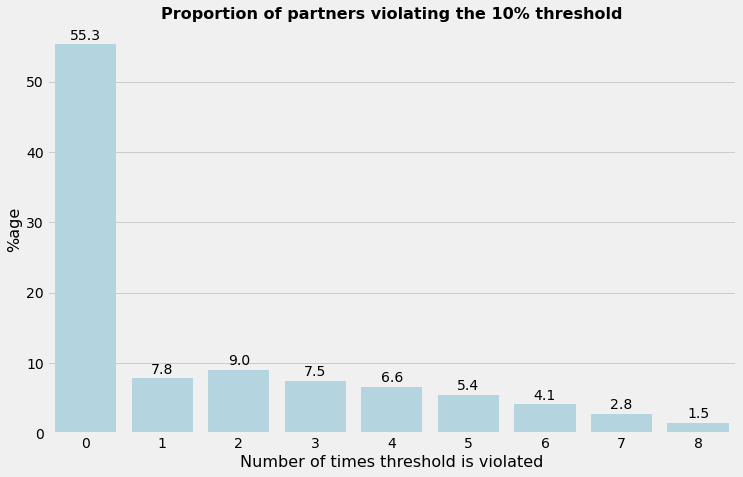

In [33]:

plt.figure(figsize=(11, 7))
splot=sns.barplot(x="percent_lt_or_gt_10", y="percent", data=partner_violaing_threshold, color='lightblue')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xlabel('Number of times threshold is violated',fontsize = 16, )
plt.ylabel('%age',fontsize = 16 )
plt.title("Proportion of partners violating the 10% threshold", fontdict= { 'fontsize': 16, 'fontweight':'bold'})


### Create a dataset from january to July in 2021 (training data) and for august(test data)

In [34]:
new_commission_cleaned.head()

,partner_position_id,month,year,title,title_group,ri_value,commission_value,total_value,total_bonus_paid,total_bonus_returned,customers_gathered_last_1d,customers_gathered_last_30d,customers_gained_last_1d,customers_gained_last_30d,club,rfm_score,rfm_category,recency,frequency,value
0,000198,1,2021,D,group_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,dormant,5082.0,0.0,0E-9
1,000198,2,2021,D,group_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,dormant,5113.0,0.0,0E-9
2,000198,3,2021,D,group_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,dormant,5141.0,0.0,0E-9
3,000198,4,2021,D,group_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,dormant,5172.0,0.0,0E-9
4,000198,5,2021,D,group_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,dormant,5202.0,0.0,0E-9


In [35]:
new_commission_cleaned.groupby('title_group').agg({'partner_position_id':'nunique', 'commission_value':['min', 'mean', 'median', 'max']})

partner_position_id commission_value                               
                        nunique              min         mean  median       max
title_group                                                                    
group_1                   19546            -60.0     0.462770    0.00    550.00
group_2                   25017           -133.3    36.550567    2.40   8771.31
group_3                     520              0.0  1574.713749  676.49  83378.68

In [36]:
new_commission_cleaned.groupby('title').agg({'partner_position_id':'nunique', 'commission_value':['min', 'mean', 'median', 'max']})

partner_position_id commission_value                                  
                  nunique              min          mean    median       max
title                                                                       
D                   19546           -60.00      0.462770      0.00    550.00
GL                    380             0.00    637.222793    548.09   5517.69
NGL                     3          8138.92  15999.799630  18170.56  22508.83
NNL                     9             0.00  22764.810959  15297.31  83378.68
QD                  19455          -114.76     13.784612      1.47   4620.60
SGL                   130             0.00   2624.974655   1766.18  13319.33
STL                  1085            -5.48    249.172243    166.04   5036.83
TL                   4732          -133.30     79.023128     17.32   8771.31

In [37]:
new_commission_cleaned.groupby('title_group').quantile([0.0, 0.1, 0.25, 0.50, 0.75, 0.8, 0.9,0.95,0.98, 0.99, 1.0])['commission_value']

title_group      
group_1      0.00      -60.0000
             0.10        0.0000
             0.25        0.0000
             0.50        0.0000
             0.75        0.0000
             0.80        0.0000
             0.90        0.0000
             0.95        0.0000
             0.98        0.6110
             0.99        4.6000
             1.00      550.0000
group_2      0.00     -133.3000
             0.10        0.0000
             0.25        0.7000
             0.50        2.4000
             0.75        9.6300
             0.80       16.3500
             0.90       71.7260
             0.95      238.4480
             0.98      411.9760
             0.99      583.0816
             1.00     8771.3100
group_3      0.00        0.0000
             0.10       54.6520
             0.25      324.8900
             0.50      676.4900
             0.75     1319.9500
             0.80     1580.3000
             0.90     2943.6420
             0.95     5306.7400
             0.98     

In [38]:
new_commission_cleaned.groupby('title').quantile([0.0, 0.1, 0.25, 0.50, 0.75, 0.8, 0.9,0.95,0.98, 0.99, 1.0])['commission_value']

title      
D      0.00      -60.0000
       0.10        0.0000
       0.25        0.0000
       0.50        0.0000
       0.75        0.0000
       0.80        0.0000
       0.90        0.0000
       0.95        0.0000
       0.98        0.6110
       0.99        4.6000
       1.00      550.0000
GL     0.00        0.0000
       0.10       36.8540
       0.25      248.7900
       0.50      548.0900
       0.75      878.5000
       0.80      980.0860
       0.90     1316.7280
       0.95     1614.4760
       0.98     2100.1600
       0.99     2514.7352
       1.00     5517.6900
NGL    0.00     8138.9200
       0.10     8211.1520
       0.25     8593.6750
       0.50    18170.5600
       0.75    20640.6650
       0.80    20818.5040
       0.90    21500.8360
       0.95    22025.9840
       0.98    22351.6184
       0.99    22430.2242
       1.00    22508.8300
NNL    0.00        0.0000
       0.10        0.0000
       0.25        0.0000
       0.50    15297.3100
       0.75    27128.2500


In [39]:
# # Title groups
# group_list = list(new_commission_cleaned.title_group.unique())
# group_value = group_list[0]
# print(group_value)
# data_for_model = new_commission_cleaned[new_commission_cleaned['title_group']==group_value]
# data_for_model.shape

In [40]:
# Titles
group_list = list(new_commission_cleaned.title.unique())
group_value = group_list[1]
print(group_value)
data_for_model = new_commission_cleaned[new_commission_cleaned['title']==group_value]
data_for_model.shape

TL


(41591, 20)

In [41]:
training_data = data_for_model[data_for_model['month']<8][['partner_position_id', 'month', 'recency', 'frequency','value', 'ri_value', 'commission_value','total_value']]


In [42]:
training_data['ri_value'] = training_data['ri_value'].astype(float)
training_data['commission_value'] = training_data['commission_value'].astype(float)
training_data['total_value'] = training_data['total_value'].astype(float)
training_data['month'] = training_data['month'].astype(object)

In [43]:
training_data.dtypes

partner_position_id     object
month                   object
recency                float64
frequency              float64
value                   object
ri_value               float64
commission_value       float64
total_value            float64
dtype: object

### Create a dataset for August (Test Data)

In [44]:
test_data = data_for_model[data_for_model['month']==8][['partner_position_id', 'month', 'recency', 'frequency','value', 'ri_value', 'commission_value','total_value']]
test_data.shape

(4679, 8)

In [45]:
test_data['ri_value'] = test_data['ri_value'].astype(float)
test_data['commission_value'] = test_data['commission_value'].astype(float)
test_data['total_value'] = test_data['total_value'].astype(float)
test_data['month'] = test_data['month'].astype(object)

In [46]:
test_data.dtypes

partner_position_id     object
month                   object
recency                float64
frequency              float64
value                   object
ri_value               float64
commission_value       float64
total_value            float64
dtype: object

In [47]:
print("Training data dimesnion = ", training_data.shape)
print("Test data dimension = ", test_data.shape)

Training data dimesnion =  (32220, 8)
Test data dimension =  (4679, 8)


### Let's try to understand commission variables (residual income, commission value and total value for both training and test)

In [48]:
### Quantile Distrubtion of Residual income, Commission value and total value 
def quantile_dist(data):
#     print("Residual income Distribution")
#     for i in np.arange(0, 1, 0.1).tolist():
#         print(i, "------->",data.ri_value.quantile(i))

    print("*************************************\n")
    print("Commision Value Distribution")
    for i in np.arange(0, 1, 0.01).tolist():
        print(i, "------->",data.commission_value.quantile(i))

#     print("*************************************\n")
#     print("Total Value Distribution")
#     for i in np.arange(0, 1, 0.1).tolist():
#         print(i, "------->",data.total_value.quantile(i))

In [49]:
quantile_dist(training_data)

*************************************

Commision Value Distribution
0.0 -------> -133.3
0.01 -------> 0.57
0.02 -------> 1.2838
0.03 -------> 1.84
0.04 -------> 2.39
0.05 -------> 2.85
0.06 -------> 3.17
0.07 -------> 3.37
0.08 -------> 3.55
0.09 -------> 3.71
0.1 -------> 3.89
0.11 -------> 4.050900000000001
0.12 -------> 4.21
0.13 -------> 4.36
0.14 -------> 4.5
0.15 -------> 4.65
0.16 -------> 4.81
0.17 -------> 4.97
0.18 -------> 5.12
0.19 -------> 5.29
0.2 -------> 5.47
0.21 -------> 5.65
0.22 -------> 5.85
0.23 -------> 6.05
0.24 -------> 6.23
0.25 -------> 6.45
0.26 -------> 6.65
0.27 -------> 6.88
0.28 -------> 7.11
0.29 -------> 7.4151000000000025
0.3 -------> 7.706999999999989
0.31 -------> 7.98
0.32 -------> 8.32
0.33 -------> 8.64
0.34 -------> 8.98
0.35000000000000003 -------> 9.346499999999995
0.36 -------> 9.73
0.37 -------> 10.17
0.38 -------> 10.63
0.39 -------> 11.18
0.4 -------> 11.69
0.41000000000000003 -------> 12.23
0.42 -------> 12.809799999999996
0.43 -------> 1

* From above in both training and test data, one can see 50% of the data less than or equal to zero in Residual income, commission value and close to 60% - 70% in total value

<AxesSubplot:xlabel='commission_value'>

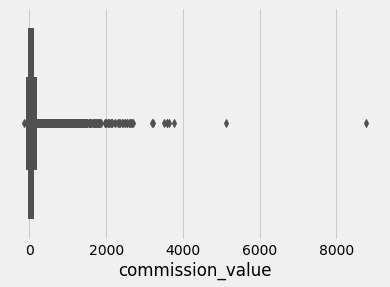

In [50]:
sns.boxplot(x=training_data[target_variable])

### Distribution plots for training data

In [51]:
def distplot(data,variable, title_var):
    sns.distplot(data[variable])
    plt.title(f"Distribution of {title_var}")
    plt.xlabel(f"{title_var}")
    sns.despine()

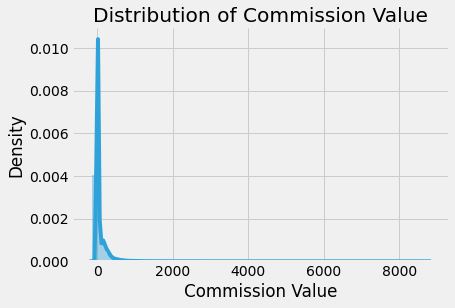

In [52]:
distplot(training_data, target_variable, 'Commission Value')

The commission distribution is far from a normal distribution, and it has a positive long thin tail, the mass of the distribution is concentrated around 0. And the tail of commission distribution far exceeds the tails of the normal distribution which leads to check skewness and kurtosis

In [53]:
print("Skewness: %f" % training_data[target_variable].skew())
print("Kurtosis: %f" % training_data[target_variable].kurt())

Skewness: 9.264322
Kurtosis: 223.007812


### Outlier Detection using different algorithms

* We will be deploying two algorithms Isolation Forest, Cluster-based Local Outlier Factor , one class SVM
* we will be putting 3% as our threshhold for outliers meaning we will be putting 3% as threshhold for number of outliers


## Isolation Forest

Its a tree based model. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

* Trained IsolationForest using the commissions data.
* Computed the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
* Classified each observation as an outlier or non-outlier.
* The visualization highlights the regions where the outliers fall.
* Please note that for visualisation we are using isolation forest and containation factor is default value(10%)

In [54]:
model_var_list = ['recency','frequency', 'value', target_variable]
X = training_data[model_var_list]
X_test = test_data[model_var_list]

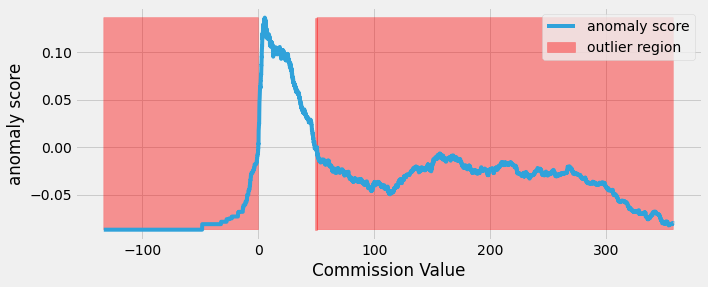

In [55]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(X[target_variable].values.reshape(-1, 1))

xx = np.linspace(X[target_variable].min(), X[target_variable].quantile(0.95), len(X)).reshape(-1,1)## usually we take max but here we took 95th percentile for better visibility

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Commission Value')
plt.show();

#### The above chart shows that any value greater than 25 are outliers, this matches with the qualtile distribution too where we observed that 90% os the data is below 23.

#### Lets train the model on data from training and apply the model on test data

* we will be using all variables along with target for this exercise

In [56]:
#### Apply on multivariate with 3% contamination
if_model=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.03),random_state=12)
if_model.fit(X)
print(if_model.get_params())

{'bootstrap': False, 'contamination': 0.03, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 12, 'verbose': 0, 'warm_start': False}


In [57]:
training_data['scores_IF'] = if_model.decision_function(X)
training_data['outlier_IF'] = if_model.predict(X)

In [58]:
training_data.head(20)

,partner_position_id,month,recency,frequency,value,ri_value,commission_value,total_value,scores_IF,outlier_IF
36,000515,1,2655.0,0.0,0E-9,33.46,33.46,30.46,0.171657,1
37,000515,2,2686.0,0.0,0E-9,35.91,35.91,32.91,0.162656,1
38,000515,3,2714.0,0.0,0E-9,31.38,31.38,28.38,0.172796,1
39,000515,4,2745.0,0.0,0E-9,31.10,31.10,28.10,0.169744,1
40,000515,5,2775.0,0.0,0E-9,31.39,31.39,28.39,0.166174,1
41,000515,6,2806.0,0.0,0E-9,32.62,32.62,29.62,0.161667,1
42,000515,7,2836.0,0.0,0E-9,32.95,32.95,29.95,0.161667,1
81,002955,1,1201.0,0.0,0E-9,4.26,4.26,1.26,0.263187,1
82,002955,2,1232.0,0.0,0E-9,4.37,4.37,1.37,0.262684,1
83,002955,3,1260.0,0.0,0E-9,4.83,4.83,3.20,0.260874,1


In [59]:
training_data.groupby('outlier_IF').partner_position_id.nunique()

outlier_IF
-1     258
 1    4608
Name: partner_position_id, dtype: int64

In [60]:
### Scores distribution for training data
print("Outlier =-1 -----> min value =",round(training_data[training_data['outlier_IF']==-1].min()['scores_IF'],2), "max value =",round(training_data[training_data['outlier_IF']==-1].max()['scores_IF'],2))
print("Outlier = 1 -----> min value =",round(training_data[training_data['outlier_IF']==1].min()['scores_IF'],2), "max value =",round(training_data[training_data['outlier_IF']==1].max()['scores_IF'],2))


Outlier =-1 -----> min value = -0.2 max value = -0.0
Outlier = 1 -----> min value = 0.0 max value = 0.27


In [61]:
### Apply the trained model on test data for August

test_data['scores_IF'] = if_model.decision_function(X_test)
test_data['outlier_IF'] = if_model.predict(X_test)

In [ ]:
test_data.groupby('outlier_IF').partner_position_id.nunique()

In [ ]:
### Scores distribution for test data
print("Outlier =-1 -----> min value =",round(test_data[test_data['outlier_IF']==-1].min()['scores_IF'],2), "max value =",round(test_data[test_data['outlier_IF']==-1].max()['scores_IF'],2))
print("Outlier = 1 -----> min value =",round(test_data[test_data['outlier_IF']==1].min()['scores_IF'],2), "max value =",round(test_data[test_data['outlier_IF']==1].max()['scores_IF'],2))


In [ ]:
test_data

In [ ]:
test_data['outlier_IF']= test_data['outlier_IF'].astype('str')
test_data.head()

In [ ]:
print(test_data['outlier_IF'].value_counts())

In [ ]:
data = test_data

x1='commission_value';x2='value'
X = test_data[[x1,x2]]

In [ ]:
data.head()

In [ ]:
data['outlier_IF'].value_counts()

In [ ]:
data = data.sample(500)
data['outlier_IF'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.set_title('Outlier Detection (Isolation forest)', fontsize = 40, loc='center')

plt.scatter(data['commission_value'], data['value'], color='k', s=100, label='Data points')
radius = (data['scores_IF'].max() - data['scores_IF']) / (data['scores_IF'].max() - data['scores_IF'].min())
plt.scatter(data['commission_value'], data['value'], s=10000 * radius, edgecolors='r', facecolors='none', label='Outlier scores')
plt.axis('tight')
legend = plt.legend(loc='upper right', fontsize = 40)
plt.xlabel("Commission Value", fontsize =30)
plt.ylabel("Monetary Value", fontsize =30)
plt.show();

#### One can see the scores distribution for training and test is quite similar

### Cluster based Local outlier factor

* The CBLOF calculates the outlier score based on cluster-based local outlier factor. An anomaly score is computed by the distance of each instance to its cluster center multiplied by the instances belonging to its cluster

* we will be fitting both bivariate and multivarate


In [ ]:
training_data_unscaled = training_data

In [ ]:
training_data_unscaled.head()

In [ ]:
#### we will scale the data using minmaxcsaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(0, 1))
training_data[[target_variable,'value','recency', 'frequency' ]] = minmax.fit_transform(training_data[[target_variable,'value','recency', 'frequency']])
training_data[[target_variable,'value','recency', 'frequency']].head()


In [ ]:
### Lets fit the model using all vars, multivariate

In [ ]:
training_data[[target_variable,'value','recency', 'frequency']].head()


In [ ]:
X1 = training_data[target_variable].values.reshape(-1,1)
X2 = training_data['value'].values.reshape(-1,1)
X3 = training_data['recency'].values.reshape(-1,1)
X4 = training_data['frequency'].values.reshape(-1,1)

X = np.concatenate((X1,X2, X3, X4),axis=1)
X

In [ ]:
from pyod.models.cblof import CBLOF
from numpy import percentile

outliers_fraction = 0.03
xx , yy, aa, bb = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100),np.linspace(0, 1, 100),np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred_cblof = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred_cblof = clf.predict(X)
n_inliers_cblof = len(y_pred_cblof) - np.count_nonzero(y_pred_cblof)

n_outliers_cblof = np.count_nonzero(y_pred_cblof == 1)
print('OUTLIERS:',n_outliers_cblof,'INLIERS:',n_inliers_cblof)


In [ ]:
training_data['scores_CBLOF'] = scores_pred_cblof
training_data['outlier_CBLOF'] = y_pred_cblof

In [ ]:
training_data.head()

In [ ]:
training_data['outlier_CBLOF'].value_counts()

#### KNN based outliers

In [ ]:
from pyod.models.knn import KNN
outliers_fraction = 0.03
# xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred_knn = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred_knn = clf.predict(X)
n_inliers_knn = len(y_pred_knn) - np.count_nonzero(y_pred_knn)
n_outliers_knn = np.count_nonzero(y_pred_knn == 1)

In [ ]:
training_data['scores_KNN'] = scores_pred_knn
training_data['outlier_KNN'] = y_pred_knn

In [ ]:
training_data.head()

In [ ]:
print("**********************************************************\n")
print("Isolation Forest")
print("**********************************************************\n")
print("Multivariate")
print("#Outliers = ", training_data[training_data['outlier_IF']==-1].shape[0], "#Inliers = ", training_data[training_data['outlier_IF']==1].shape[0] )

print("**********************************************************\n")
print("CBLOF")     
print("\n**********************************************************\n")     
print("Multivariate")
print("#Outliers = ", n_outliers_cblof, "#Inliers = ", n_inliers_cblof )


print("**********************************************************\n")
print("KNN")     
print("\n**********************************************************\n")     
print("Multivariate")
print("#Outliers = ", n_outliers_knn, "#Inliers = ", n_inliers_knn )


### Lets plot the contour plot using CBLOF

In [ ]:
training_data.head()

In [ ]:
X1 = training_data[target_variable].values.reshape(-1,1)
X2 = training_data['value'].values.reshape(-1,1)
X3 = training_data['recency'].values.reshape(-1,1)
X4 = training_data['frequency'].values.reshape(-1,1)

X_4 = np.concatenate((X1,X2,X3,X4),axis=1)

In [ ]:
from pyod.models.cblof import CBLOF
from numpy import percentile

outliers_fraction = 0.03
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X_4)
# predict raw anomaly score
scores_pred = clf.decision_function(X_4) * -1
      
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X_4)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)


In [ ]:
import matplotlib
plt.figure(figsize=(8, 8))

df1 = training_data
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_commission = np.array(df1[target_variable][df1['outlier'] == 0]).reshape(-1,1)
inliers_value = np.array(df1['value'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_commission = df1[target_variable][df1['outlier'] == 1].values.reshape(-1,1)
outliers_value = df1['value'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold value to consider a datapoint inlier or outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
print(threshold)       
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
print(np.linspace(Z.min(), threshold, 7))
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 5),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_commission, inliers_value, c='white',s=50, edgecolor='k')
    
c = plt.scatter(outliers_commission, outliers_value, c='black',s=10, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='upper right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();